## Preliminaries

### Connecto to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL/Homework1

Mounted at /gdrive
/gdrive/My Drive/AN2DL/Homework1


### Import Libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

from tensorflow.keras import mixed_precision
AUTOTUNE = tf.data.AUTOTUNE

# Import other libraries
import cv2
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as inception_preprocess_input
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import hashlib

2.14.0


connect to the tpu

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)

    policy = mixed_precision.Policy('mixed_bfloat16')

except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

    policy = mixed_precision.Policy('mixed_float16')

    #!pip install keras-cv
    #import keras_cv

# Import the mixed precision according to the strategy
mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Not connected to a TPU runtime. Using CPU/GPU strategy
Compute dtype: float16
Variable dtype: float32


import base paths

In [ ]:
base_path = 'networks/'
submission_file ='ToySubmission/'

### Import data

##### Load the dataset

In [ ]:
data = np.load('data/public_data.npz', allow_pickle=True)

# Extract the RGB images and labels
images = data['data']  # 4-dimensional numpy array of shape (5200, 96, 96, 3)
labels = data['labels']  # 1-dimensional numpy array of shape (5200,)

In [ ]:
WHOLE_DS = False

##### Outliers cleaning

In [ ]:
def calculate_hash(image):
    """
    Calculate the hash value for an image.
    """
    hash_object = hashlib.md5(image.tobytes())
    return hash_object.hexdigest()

shreck_hash = calculate_hash(images[58])
trololo_hash = calculate_hash(images[338])


# Create a hash map to track unique images
unique_images_map = {}

# Indices to keep track of unique images
unique_indices = []
shreck_indices=[]
trololo_indices=[]

unique_counter = 0
shreck_counter = 0
trololo_counter = 0
# Iterate through the images
for i, image in enumerate(images):
    # Calculate the hash value for the current image
    image_hash = calculate_hash(image)

    if image_hash == shreck_hash:
      shreck_indices.append(i)
      continue
    if image_hash == trololo_hash:
      trololo_indices.append(i)
      continue

    # Check if the hash value is already in the hash map
    if image_hash not in unique_images_map:
        # Add the hash value to the hash map
        unique_images_map[image_hash] = i
        # Add the index to the list of unique indices
        unique_indices.append(i)
        unique_counter = unique_counter+1

print("There are "+str(len(unique_indices))+" unique non-outliers")
print("There are "+str(len(shreck_indices))+" shrecks")
print("There are "+str(len(trololo_indices))+" trololos")

percentage_shreck = len(shreck_indices)/len(images)
percentage_trololo = len(trololo_indices)/len(images)
print("The percentage of shrecks in the original dataset is "+str(percentage_shreck))
print("The percentage of trololos in the original dataset is "+str(percentage_trololo))

num_shrecks_to_add = 0 #round(percentage_shreck * len(unique_indices))
num_trololo_to_add = 0 #round(percentage_trololo * len(unique_indices))

print("Adding "+str(num_shrecks_to_add)+" Shrecks")
print("Adding "+str(num_trololo_to_add)+" Trololos")

unique_indices+=(shreck_indices[:num_shrecks_to_add])
unique_indices+=(trololo_indices[:num_trololo_to_add])

# Create a new dataset with unique images
images = images[unique_indices]
labels = labels[unique_indices]

print("The new dataset has "+str(len(images))+" images")

There are 4850 unique non-outliers
There are 98 shrecks
There are 98 trololos
The percentage of shrecks in the original dataset is 0.018846153846153846
The percentage of trololos in the original dataset is 0.018846153846153846
Adding 0 Shrecks
Adding 0 Trololos
The new dataset has 4850 images


##### Split

In [ ]:
# Define the classes
classes = ['healthy', 'unhealthy']
class_to_index = {cls: idx for idx, cls in enumerate(classes)}

# Convert string labels to integer labels
labels_encoded = np.array([class_to_index[label] for label in labels])

# Create a one-hot encoding
labels_encoded = tf.keras.utils.to_categorical(labels_encoded, num_classes=len(classes))

if WHOLE_DS:
    X_train = images
    y_train = labels_encoded
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
else:
    # Split data into train_val and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels_encoded, random_state=seed, test_size=50, stratify=np.argmax(labels_encoded,axis=1))

    # Split data into training and validation sets, maintaining class distribution
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=640, stratify=np.argmax(y_train_val,axis=1))

    # Print shapes of the datasets
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Define input shape and output shape
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]

print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")

X_train shape: (4160, 96, 96, 3), y_train shape: (4160, 2)
X_val shape: (640, 96, 96, 3), y_val shape: (640, 2)
X_test shape: (50, 96, 96, 3), y_test shape: (50, 2)
Input Shape: (96, 96, 3), Output Shape: 2


#### Visualize images

In [ ]:
# num_img = 10
# # 3 5 6 10 14
# k =15
# Brightness = tf.keras.Sequential([
#   tfkl.RandomBrightness(0.5, value_range=(0,1)),
# ])

# X_train_Brightness = Brightness(X_train)

# fig, axes = plt.subplots(2, num_img, figsize=(20,4))
# for i in range(num_img):
#     ax = axes[0,i%num_img]
#     ax.imshow(X_train[k*num_img+i])
#     ax = axes[1,i%num_img]
#     ax.imshow(X_train_Brightness[k*num_img+i])
# plt.tight_layout()
# plt.show()

### Hyperparameters

In [ ]:
# Define batch size, number of epochs, learning rate

if WHOLE_DS:
  epochs = 50 # Early Stopping best epoch
else:
  epochs = 200
batch_size = 32

learning_rate = 5e-4

# Dropout
dropout_rate=0.2

# Early Stopping
es_patience=15

# # Augmentation
# bright=0.5
# contrast=0.2
# zoom_factor=(0.3, 0.3)

# # Learing Rate Scheduler
# reducing_factor=0.1
# lr_patience=10
# min_lr=1e-7

# Print batch size, epochs, learning rate
print(f"Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {learning_rate}")
print(f"Dropout rate: {dropout_rate} ")
print(f"Early stopping patience: {es_patience}")

Batch Size: 32, Epochs: 200, Learning Rate: 0.0005
Dropout rate: 0.2 
Early stopping patience: 15


### Utils

In [ ]:
def schedule(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.07)

es=tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=es_patience, restore_best_weights=True, mode='max')
lrs=tfk.callbacks.LearningRateScheduler(schedule, verbose=0)
#lrs=tfk.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)


checkpoint_name = "kerasNet"
checkpoint_folder = base_path + "checkpoint"

# Define two callback functions for early stopping and learnin g rate reduction
callbacks=[
    es,
    # tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=reducing_factor, patience=lr_patience, min_lr=min_lr, mode='max'),
    lrs,
    # tfk.callbacks.ModelCheckpoint( os.path.join(checkpoint_folder, checkpoint_name+".keras") ) # High Google Drive Storage Demanding
]

# Print the defined callbacks
print("Callbacks:")
for callback in callbacks:
    print(callback)

Callbacks:


## JJsuperNet

In [ ]:
model_name = 'EfficientNetV2B3_noOutliers'

### Define the model

In [ ]:
def create_model():

    # Augment the input
    augmentation = tfk.Sequential([
        tfkl.RandomFlip(name='RandomFlip'),
        # tfkl.RandomContrast(factor=contrast),
        # tfkl.RandomBrightness(bright, value_range=(0,1)),
        tfkl.ZeroPadding2D((2, 2), name='ZeroPadding_2x2'),
        tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop')
    ], name='Augment')

    # Download and plot the EfficientNet model
    # Create an input layer with shape (96, 96, 3)
    inputs = tfk.Input(input_shape)

    augmented_inputs = augmentation(inputs)

    supernet = tfk.applications.EfficientNetV2B3(
        include_top=False,
        weights="imagenet",
        #input_shape=input_shape,
        input_tensor=augmented_inputs,
        pooling="avg",
        classes=2
    )

    # Use the supernet as feature extractor, i.e. freeze all its weigths
    supernet.trainable = True

    # Add a Dense layer with 2 units and softmax activation as the classifier
    y = tfkl.Dense(128, activation="relu")(supernet.output)
    y2 = tfkl.Dropout(dropout_rate)(y)
    outputs = tfkl.Dense(output_shape, activation='softmax')(y2)

    # Create a Model connecting input and output
    tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics=['accuracy'])

    return tl_model

with strategy.scope():
  # Create a Model connecting input and output
  tl_model = create_model()

tl_model.summary()

52606240/52606240 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Augment (Sequential)        (None, 96, 96, 3)            0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 96, 96, 3)            0         ['Augment[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 96, 96, 3)            0         ['rescaling[0][0]']           
 on)                         


### Train the model and save its history

In [ ]:
if WHOLE_DS:
  history = tl_model.fit(
      x=X_train,
      y=y_train,
      batch_size=batch_size,
      epochs=epochs,
      callbacks=[lrs]
  ).history
else:
  history = tl_model.fit(
      x=X_train,
      y=y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(X_val, y_val),
      callbacks=[es,lrs]
  ).history

Epoch 1/200
130/130 [==============================] - 100s 147ms/step - loss: 0.4660 - accuracy: 0.7784 - val_loss: 0.4369 - val_accuracy: 0.8188 - lr: 5.0000e-04
Epoch 2/200
130/130 [==============================] - 12s 92ms/step - loss: 0.3416 - accuracy: 0.8555 - val_loss: 0.3238 - val_accuracy: 0.8625 - lr: 5.0000e-04
Epoch 3/200
130/130 [==============================] - 14s 104ms/step - loss: 0.2769 - accuracy: 0.8865 - val_loss: 0.3004 - val_accuracy: 0.8781 - lr: 5.0000e-04
Epoch 4/200
130/130 [==============================] - 13s 103ms/step - loss: 0.2385 - accuracy: 0.9077 - val_loss: 0.3285 - val_accuracy: 0.8844 - lr: 5.0000e-04
Epoch 5/200
130/130 [==============================] - 13s 100ms/step - loss: 0.2120 - accuracy: 0.9168 - val_loss: 0.3864 - val_accuracy: 0.8719 - lr: 5.0000e-04
Epoch 6/200
130/130 [==============================] - 13s 103ms/step - loss: 0.2034 - accuracy: 0.9228 - val_loss: 0.3428 - val_accuracy: 0.9000 - lr: 5.0000e-04
Epoch 7/200
130/130 [=

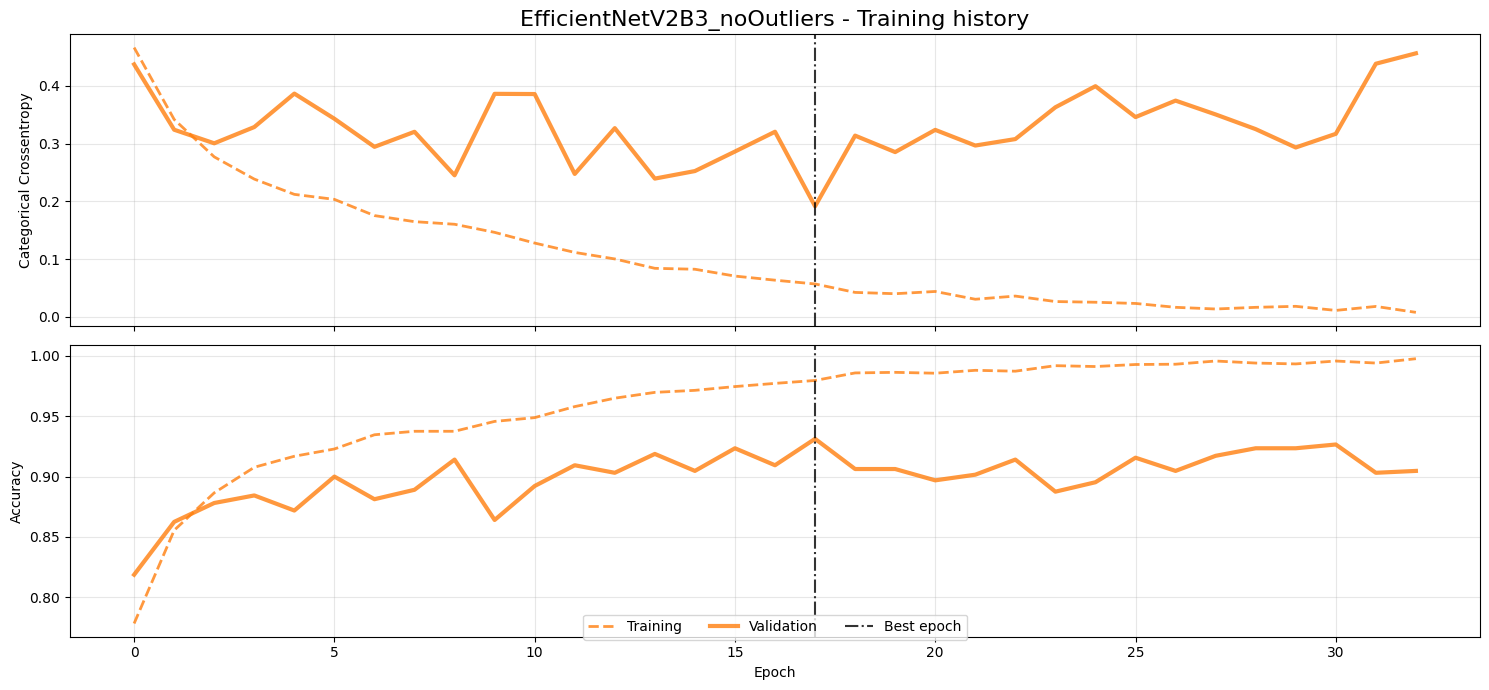

Validation best epoch:  17
Test label Shape: (50, 2)
Evaluate on test data
2/2 [==============================] - 5s 448ms/step - loss: 0.5044 - accuracy: 0.8600
test loss, test acc: [0.5043554902076721, 0.8600000143051147]


In [ ]:
# Plot training and validation performance metrics
fig, ax = plt.subplots(2, 1, figsize=(15, 7), sharex=True)

ax[0].set_title(model_name+" - Training history", fontsize=16)

# Plot training and validation loss
ax[0].plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2, linestyle='--')
if not WHOLE_DS:
  ax[0].plot(history['val_loss'], label='Validation', alpha=0.8, color='#ff7f0e', linewidth=3)
  ax[0].axvline(es.best_epoch, color='k', ls="-.", alpha=0.8, label='Best epoch')
ax[0].set_ylabel('Categorical Crossentropy')
ax[0].grid(alpha=0.3)

# Plot training and validation accuracy, highlighting the best epoch
ax[1].plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2, linestyle='--')
if not WHOLE_DS:
  ax[1].plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#ff7f0e', linewidth=3)
  ax[1].axvline(es.best_epoch, color='k', ls="-.", alpha=0.8, label='Best epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].grid(alpha=0.3)
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 0.1),
          fancybox=True, ncol=3)
plt.tight_layout()

#plt.savefig(os.path.join(checkpoint_folder, checkpoint_name+"_training_hist.pdf"))

plt.show()

if not WHOLE_DS:
  print("Validation best epoch: ",es.best_epoch)
  print("Test label Shape:", y_test.shape)
  print("Evaluate on test data")
  print("test loss, test acc:", tl_model.evaluate(X_test, y_test))

## Save the model

In [ ]:
saved_model_filepath = base_path + model_name

submission_model_filepath = submission_file + 'SubmissionModel'

print(submission_model_filepath)

ToySubmission/SubmissionModel


In [ ]:
# Export trained model
tl_model.save(saved_model_filepath)

In [ ]:
tl_model.save(submission_model_filepath)

## Make inference

In [ ]:
%cd  /gdrive/My Drive/AN2DL/Homework1/ToySubmission
from model import model as model_py

# Predict, perform one-hot encoding and convert to a numpy array
predictions = tf.one_hot(model_py(os.getcwd()).predict(X_test), depth=2).numpy()

%cd  /gdrive/My Drive/AN2DL/Homework1

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Compute classification metrics
print('Accuracy',accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1)).round(4))
print('F1',f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro').round(4))
print('Precision',precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro').round(4))
print('Recall',recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro').round(4))



/gdrive/My Drive/AN2DL/Homework1/ToySubmission
/gdrive/My Drive/AN2DL/Homework1
Predictions Shape: (50, 2)
Accuracy 0.86
F1 0.8417
Precision 0.8619
Recall 0.8299
